# Boyer–Moore Benchmark Analysis (Multi-Dataset)

This notebook mirrors the visualization style of the Suffix Arrays & Trees study. It ingests `bm_benchmark_results.csv`, groups real (GCA) and synthetic genomes, and compares Boyer–Moore against Python's regex implementation across multiple datasets and synthetic sequences generated via `synthetic.py`. The plots now aggregate measurements with error bars to highlight how each algorithm scales across cohorts.

In [2]:
# 1) Setup, imports, and data ingestion
from __future__ import annotations

import os
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

sns.set_theme(style="whitegrid", context="talk")
plt.rcParams.update({"figure.autolayout": True})

NOTEBOOK_DIR = Path(__file__).resolve().parent if "__file__" in globals() else Path.cwd()
CSV_PATH = NOTEBOOK_DIR / "bm_benchmark_results.csv"
OUTPUT_DIR = NOTEBOOK_DIR / "graphs"
OUTPUT_DIR.mkdir(exist_ok=True)

if not CSV_PATH.exists():
    raise FileNotFoundError(f"CSV not found: {CSV_PATH}. Run benchmark.py first.")

df = pd.read_csv(CSV_PATH)
if "dataset_group" not in df.columns:
    df["dataset_group"] = np.where(df["dataset_name"].str.upper().str.startswith("SYNTH"), "synthetic", "gca")

df["algorithm"] = df["algorithm"].str.lower()
df["metric_type"] = df["metric_type"].str.lower()

total_rows = len(df)
datasets = df["dataset_name"].nunique()
print(f"Loaded {total_rows} measurements across {datasets} dataset(s)")
print(df.groupby(["dataset_group", "algorithm", "metric_type"]).size())

df.head()

Loaded 1950 measurements across 50 dataset(s)
dataset_group  algorithm     metric_type 
synthetic      boyer_moore   construction    350
                             search          800
               python_regex  search          800
dtype: int64


,algorithm,dataset_name,dataset_group,text_length_n,pattern_length_m,metric_type,time_sec,memory_bytes,matches
0,boyer_moore,GCA_000005845.2_ASM584v2_genomic.fna,synthetic,0,6,construction,0.000017,0,0
1,boyer_moore,GCA_000005845.2_ASM584v2_genomic.fna,synthetic,1000,6,search,0.000123,0,0
2,python_regex,GCA_000005845.2_ASM584v2_genomic.fna,synthetic,1000,6,search,0.000063,0,0
3,boyer_moore,GCA_000005845.2_ASM584v2_genomic.fna,synthetic,2000,6,search,0.000221,0,0
4,python_regex,GCA_000005845.2_ASM584v2_genomic.fna,synthetic,2000,6,search,0.000005,0,0


In [3]:
# 2) Helper utilities and curated DataFrames
from typing import Callable, Dict

FIXED_PATTERN_LENGTH = 6
PATTERN_LENGTHS = [5, 10, 20, 50, 100, 200]

GROUP_DISPLAY_NAMES = {
    "synthetic": "Synthetic Datasets (Average)",
    "gca": "GCA Datasets (Average)",
    "all": "All Datasets (Average)",
}
GROUP_ORDER = ["synthetic", "gca", "all"]
GROUP_FILTERS: Dict[str, Callable[[pd.DataFrame], pd.DataFrame]] = {
    "synthetic": lambda data: data[data["dataset_group"] == "synthetic"],
    "gca": lambda data: data[data["dataset_group"] == "gca"],
    "all": lambda data: data,
}


def summarize_metric(metric_df: pd.DataFrame, x_col: str, value_col: str) -> Dict[str, pd.DataFrame]:
    summaries: Dict[str, pd.DataFrame] = {}
    for key in GROUP_ORDER:
        subset = GROUP_FILTERS[key](metric_df)
        if subset.empty:
            continue
        summary = (
            subset.groupby(["algorithm", x_col], as_index=False)[value_col]
            .agg(mean_value="mean", std_value="std", count="count")
        )
        summary["std_value"] = summary["std_value"].fillna(0.0)
        summary["count"] = summary["count"].clip(lower=1)
        summary["sem_value"] = summary["std_value"] / np.sqrt(summary["count"])
        summary["group_key"] = key
        summaries[key] = summary
    return summaries


def plot_error_bars(ax, data: pd.DataFrame, x_col: str, color_map: Dict[str, str]):
    for algorithm, color in color_map.items():
        subset = data[data["algorithm"] == algorithm]
        if subset.empty:
            continue
        ax.errorbar(
            subset[x_col],
            subset["mean_value"],
            yerr=subset["sem_value"],
            fmt="none",
            ecolor=color,
            elinewidth=1.2,
            capsize=4,
            alpha=0.7,
        )


search_df = df[df["metric_type"] == "search"].copy()
construction_df = df[df["metric_type"] == "construction"].copy()
search_df["throughput_mb_s"] = np.where(
    search_df["time_sec"] > 0,
    (search_df["text_length_n"] / search_df["time_sec"]) / 1_000_000,
    np.nan,
)

text_search_df = search_df[
    (search_df["pattern_length_m"] == FIXED_PATTERN_LENGTH) & (search_df["text_length_n"] > 0)
]
pattern_search_df = search_df[search_df["pattern_length_m"].isin(PATTERN_LENGTHS)]
construction_pattern_df = construction_df[
    construction_df["pattern_length_m"].isin([FIXED_PATTERN_LENGTH, *PATTERN_LENGTHS])
]

print(
    f"Prepared {len(search_df)} search rows and {len(construction_df)} construction rows for plotting"
)


Prepared 1600 search rows and 350 construction rows for plotting


Saved search-time plot for synthetic to c:\Users\user\AAD_project\STARK\Boyer_Moore\graphs\graph_time_vs_n_synthetic.png


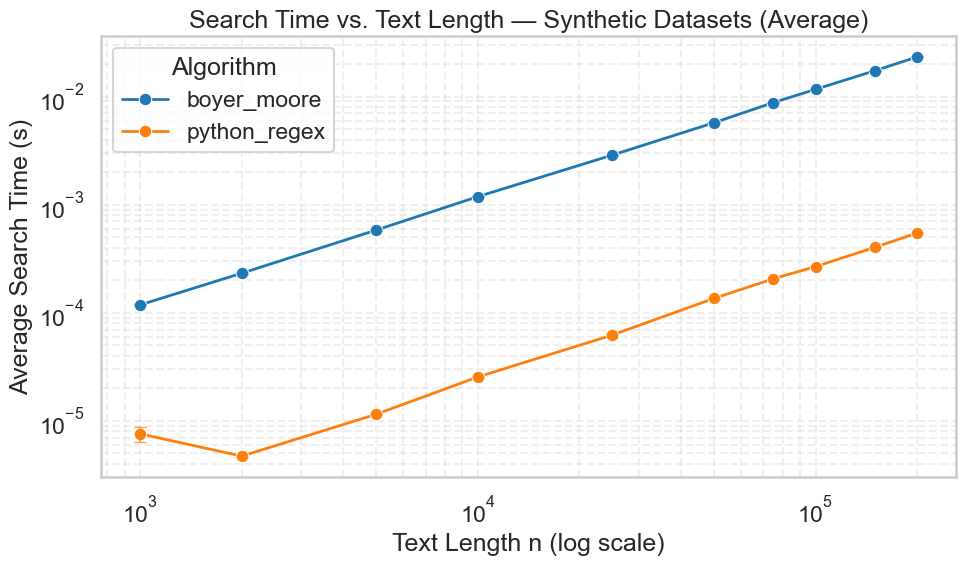

Saved search-time plot for all to c:\Users\user\AAD_project\STARK\Boyer_Moore\graphs\graph_time_vs_n_all.png


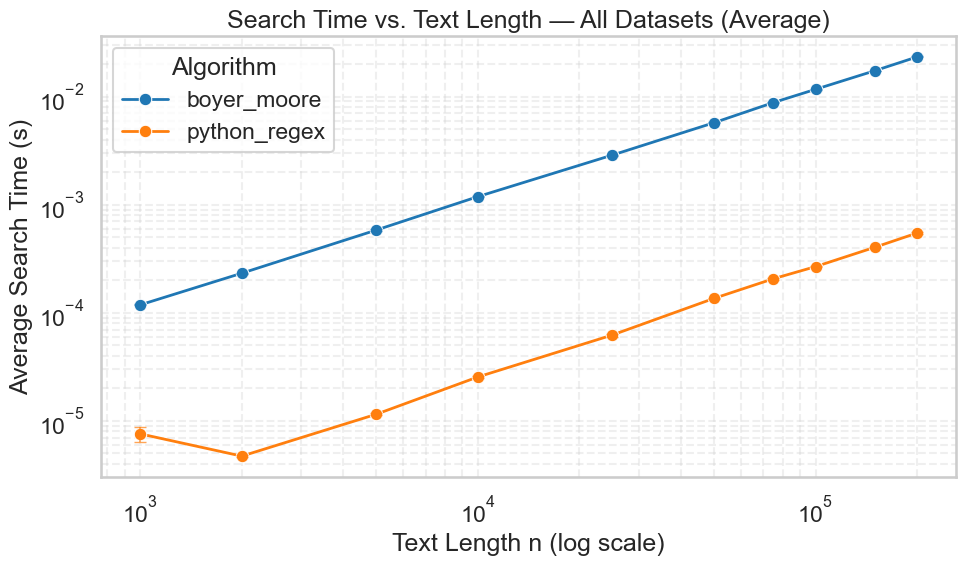

In [4]:
# 3) Search time vs. text length (EcoRI pattern, multiple datasets)
time_summaries = summarize_metric(text_search_df, "text_length_n", "time_sec")

if not time_summaries:
    print("No search data available for varying text sizes.")
else:
    base_palette = sns.color_palette("tab10")
    for group_key in GROUP_ORDER:
        summary = time_summaries.get(group_key)
        if summary is None:
            continue
        algo_order = sorted(summary["algorithm"].unique())
        color_map = {algo: base_palette[i % len(base_palette)] for i, algo in enumerate(algo_order)}

        plt.figure(figsize=(10, 6))
        sns.lineplot(
            data=summary,
            x="text_length_n",
            y="mean_value",
            hue="algorithm",
            palette=color_map,
            marker="o",
            linewidth=2,
        )
        ax = plt.gca()
        plot_error_bars(ax, summary, "text_length_n", color_map)
        ax.set_xscale("log")
        ax.set_yscale("log")
        ax.set_xlabel("Text Length n (log scale)")
        ax.set_ylabel("Average Search Time (s)")
        ax.set_title(f"Search Time vs. Text Length — {GROUP_DISPLAY_NAMES[group_key]}")
        ax.grid(True, which="both", ls="--", alpha=0.3)
        ax.legend(title="Algorithm")
        output_path = OUTPUT_DIR / f"graph_time_vs_n_{group_key}.png"
        plt.savefig(output_path, dpi=200, bbox_inches="tight")
        print(f"Saved search-time plot for {group_key} to {output_path}")
        plt.show()


Saved throughput plot for synthetic to c:\Users\user\AAD_project\STARK\Boyer_Moore\graphs\graph_throughput_vs_n_synthetic.png


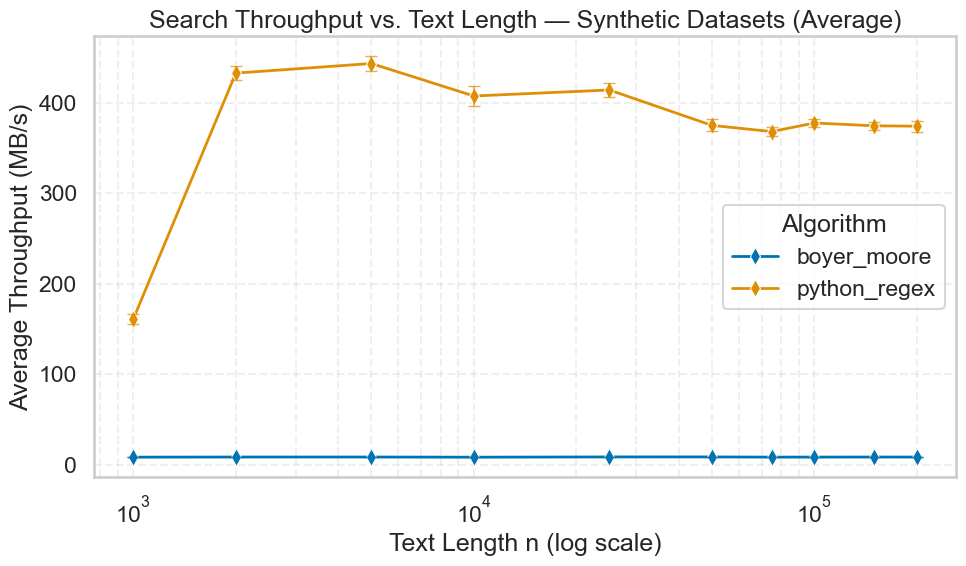

Saved throughput plot for all to c:\Users\user\AAD_project\STARK\Boyer_Moore\graphs\graph_throughput_vs_n_all.png


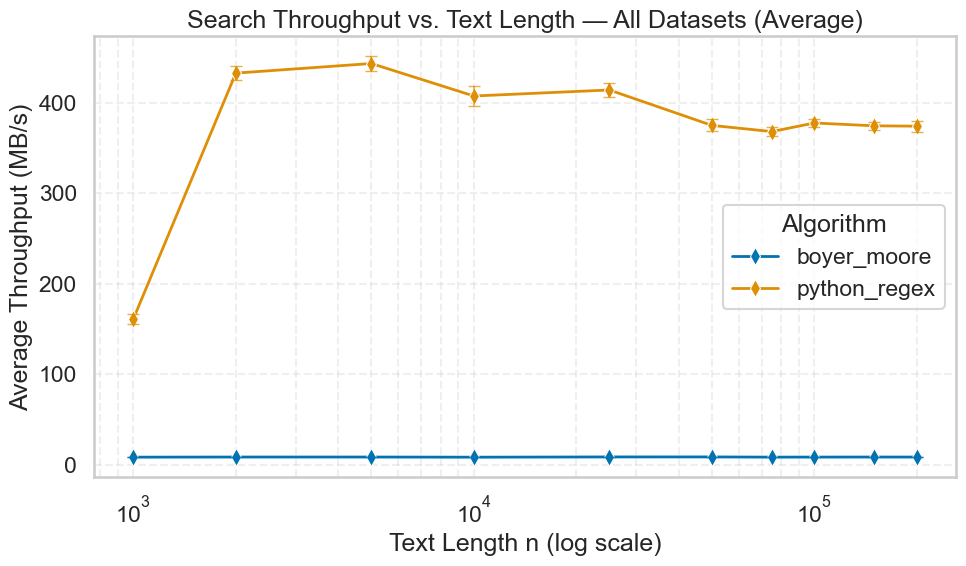

In [5]:
# 4) Throughput (MB/s) vs. text length
throughput_df = text_search_df.dropna(subset=["throughput_mb_s"]).copy()
throughput_summaries = summarize_metric(throughput_df, "text_length_n", "throughput_mb_s")

if not throughput_summaries:
    print("No throughput data available.")
else:
    base_palette = sns.color_palette("colorblind")
    for group_key in GROUP_ORDER:
        summary = throughput_summaries.get(group_key)
        if summary is None:
            continue
        algo_order = sorted(summary["algorithm"].unique())
        color_map = {algo: base_palette[i % len(base_palette)] for i, algo in enumerate(algo_order)}

        plt.figure(figsize=(10, 6))
        sns.lineplot(
            data=summary,
            x="text_length_n",
            y="mean_value",
            hue="algorithm",
            palette=color_map,
            marker="d",
            linewidth=2,
        )
        ax = plt.gca()
        plot_error_bars(ax, summary, "text_length_n", color_map)
        ax.set_xscale("log")
        ax.set_xlabel("Text Length n (log scale)")
        ax.set_ylabel("Average Throughput (MB/s)")
        ax.set_title(f"Search Throughput vs. Text Length — {GROUP_DISPLAY_NAMES[group_key]}")
        ax.grid(True, which="both", ls="--", alpha=0.3)
        ax.legend(title="Algorithm")
        output_path = OUTPUT_DIR / f"graph_throughput_vs_n_{group_key}.png"
        plt.savefig(output_path, dpi=200, bbox_inches="tight")
        print(f"Saved throughput plot for {group_key} to {output_path}")
        plt.show()


Saved pattern-length search plot for synthetic to c:\Users\user\AAD_project\STARK\Boyer_Moore\graphs\graph_time_vs_m_synthetic.png


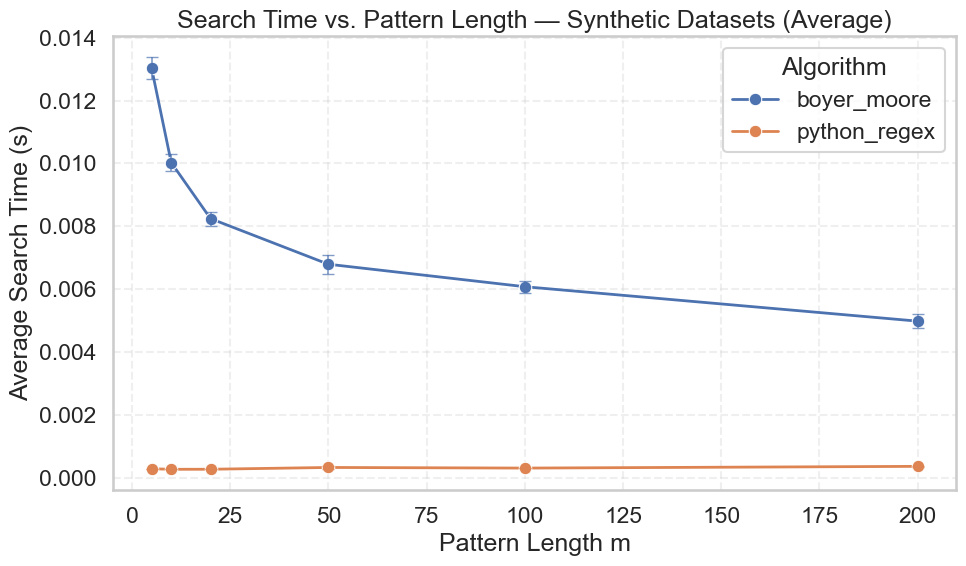

Saved pattern-length search plot for all to c:\Users\user\AAD_project\STARK\Boyer_Moore\graphs\graph_time_vs_m_all.png


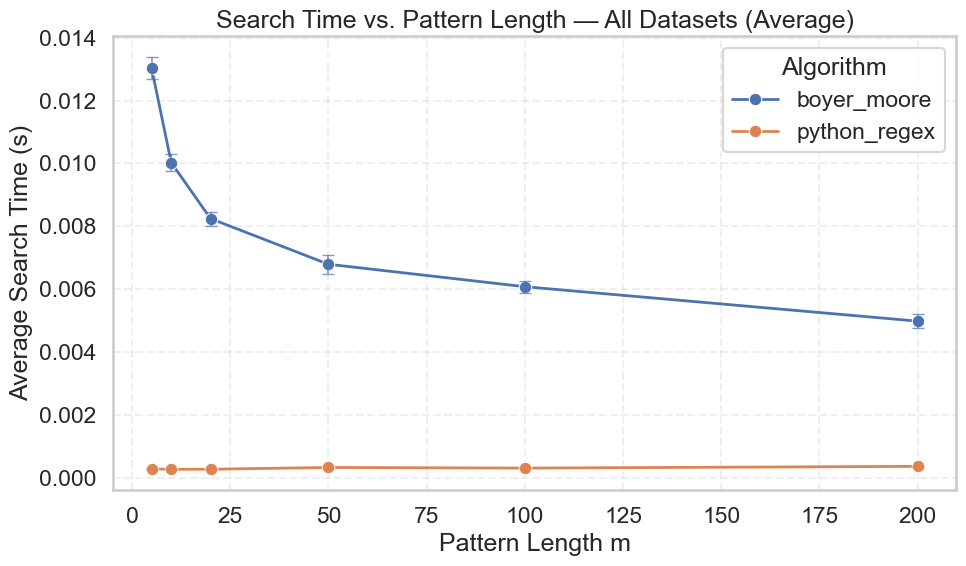

In [6]:
# 5) Search time vs. pattern length (fixed text slices per dataset)
pattern_time_summaries = summarize_metric(pattern_search_df, "pattern_length_m", "time_sec")

if not pattern_time_summaries:
    print("No pattern-length search data available.")
else:
    base_palette = sns.color_palette("deep")
    for group_key in GROUP_ORDER:
        summary = pattern_time_summaries.get(group_key)
        if summary is None:
            continue
        algo_order = sorted(summary["algorithm"].unique())
        color_map = {algo: base_palette[i % len(base_palette)] for i, algo in enumerate(algo_order)}

        plt.figure(figsize=(10, 6))
        sns.lineplot(
            data=summary,
            x="pattern_length_m",
            y="mean_value",
            hue="algorithm",
            palette=color_map,
            marker="o",
            linewidth=2,
        )
        ax = plt.gca()
        plot_error_bars(ax, summary, "pattern_length_m", color_map)
        ax.set_xlabel("Pattern Length m")
        ax.set_ylabel("Average Search Time (s)")
        ax.set_title(f"Search Time vs. Pattern Length — {GROUP_DISPLAY_NAMES[group_key]}")
        ax.grid(True, ls="--", alpha=0.3)
        ax.legend(title="Algorithm")
        output_path = OUTPUT_DIR / f"graph_time_vs_m_{group_key}.png"
        plt.savefig(output_path, dpi=200, bbox_inches="tight")
        print(f"Saved pattern-length search plot for {group_key} to {output_path}")
        plt.show()


Saved construction plot for synthetic to c:\Users\user\AAD_project\STARK\Boyer_Moore\graphs\graph_construction_vs_m_synthetic.png


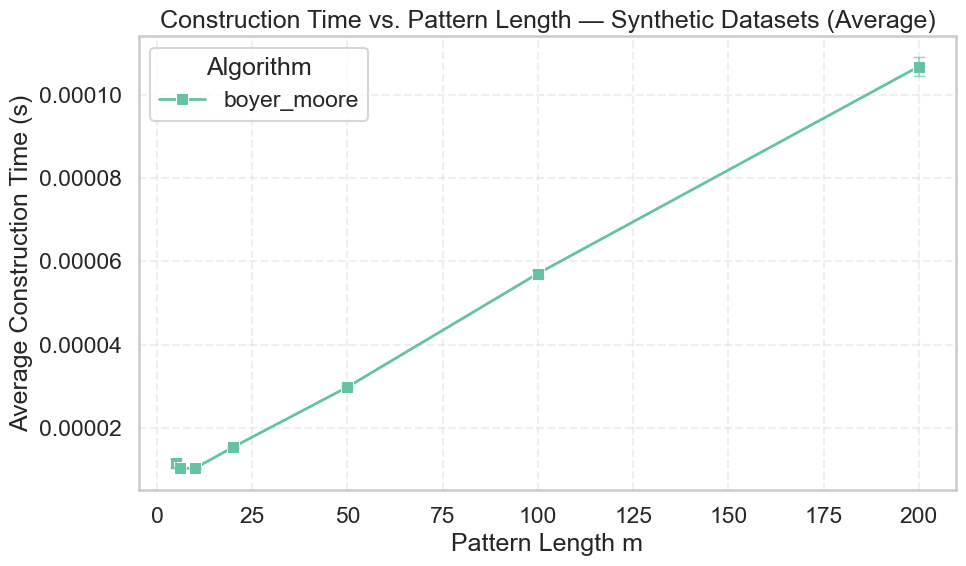

Saved construction plot for all to c:\Users\user\AAD_project\STARK\Boyer_Moore\graphs\graph_construction_vs_m_all.png


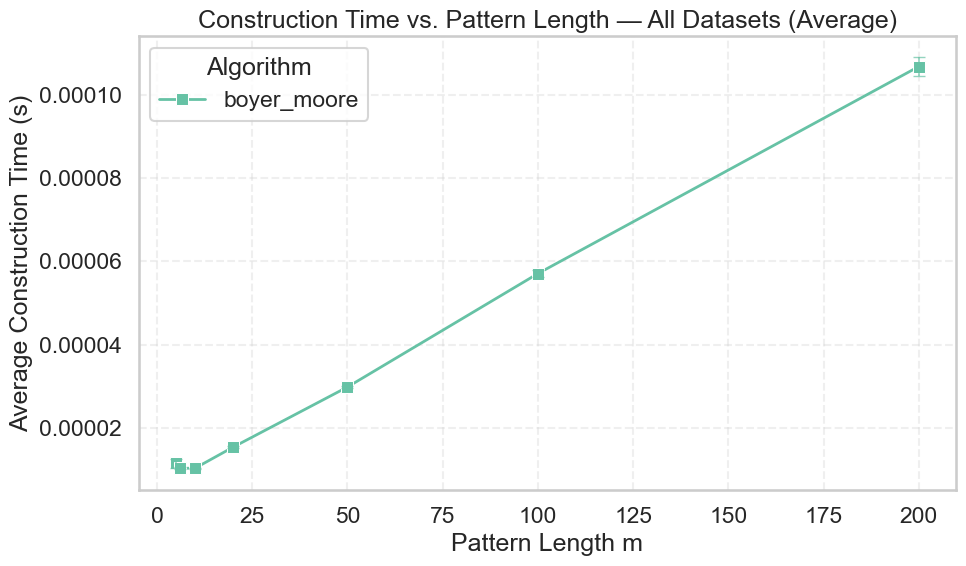

In [7]:
# 6) Construction time vs. pattern length (Boyer–Moore preprocessing)
construction_summaries = summarize_metric(construction_pattern_df, "pattern_length_m", "time_sec")

if not construction_summaries:
    print("No construction data available.")
else:
    base_palette = sns.color_palette("Set2")
    for group_key in GROUP_ORDER:
        summary = construction_summaries.get(group_key)
        if summary is None:
            continue
        algo_order = sorted(summary["algorithm"].unique())
        color_map = {algo: base_palette[i % len(base_palette)] for i, algo in enumerate(algo_order)}

        plt.figure(figsize=(10, 6))
        sns.lineplot(
            data=summary,
            x="pattern_length_m",
            y="mean_value",
            hue="algorithm",
            palette=color_map,
            marker="s",
            linewidth=2,
        )
        ax = plt.gca()
        plot_error_bars(ax, summary, "pattern_length_m", color_map)
        ax.set_xlabel("Pattern Length m")
        ax.set_ylabel("Average Construction Time (s)")
        ax.set_title(f"Construction Time vs. Pattern Length — {GROUP_DISPLAY_NAMES[group_key]}")
        ax.grid(True, ls="--", alpha=0.3)
        ax.legend(title="Algorithm")
        output_path = OUTPUT_DIR / f"graph_construction_vs_m_{group_key}.png"
        plt.savefig(output_path, dpi=200, bbox_inches="tight")
        print(f"Saved construction plot for {group_key} to {output_path}")
        plt.show()


## Match Location Map (Boyer–Moore)

This interactive section mirrors the suffix-array workbook: pick a dataset from `Boyer_Moore/dataset`, optionally trim the prefix examined, and highlight exactly where a motif appears. Workflow:

1. Adjust `MATCH_MAP_DATASET`/`MATCH_MAP_PREFIX_LEN` below so they point to the FASTA file and prefix size you care about.
2. Run the next cell and enter a motif when prompted (press Enter to keep the default EcoRI site `GAATTC`).
3. Inspect the “event plot” (every vertical line is a hit) plus the density histogram to see whether matches cluster inside particular genome regions.

If you have not copied any files into `Boyer_Moore/dataset`, rerun `synthetic.py` to generate one before executing this cell.

Dataset: GCA_000005845.2_ASM584v2_genomic.fna
Loaded prefix length: 120,000 characters
Found 14 match(es) for 'GAATTC' in the selected prefix.
Found 14 match(es) for 'GAATTC' in the selected prefix.


,match_index,position,percent_of_prefix
0,1,3841,3.200833
1,2,12888,10.740000
2,3,32544,27.120000
3,4,50236,41.863333
4,5,56281,46.900833
5,6,96859,80.715833
6,7,101760,84.800000
7,8,102291,85.242500
8,9,103130,85.941667
9,10,105415,87.845833


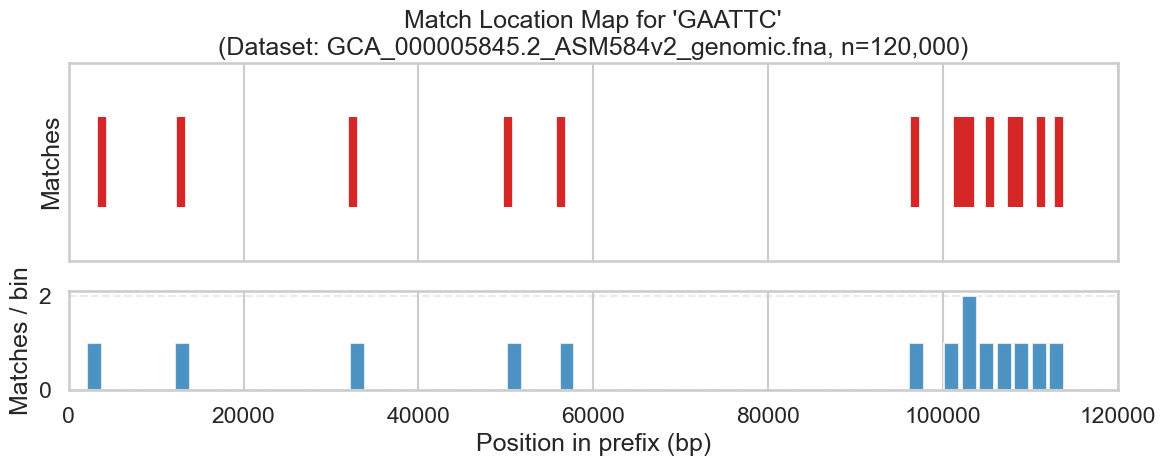

In [8]:
# 7) Interactive match location map
from boyer_moore import BoyerMoore
from utils import read_fasta_single_sequence

MATCH_MAP_DATASET = "GCA_000005845.2_ASM584v2_genomic.fna"
MATCH_MAP_PREFIX_LEN = 120_000
MATCH_MAP_DEFAULT_PATTERN = "GAATTC"

DATASET_DIR = NOTEBOOK_DIR / "dataset"
dataset_path = DATASET_DIR / MATCH_MAP_DATASET
if not dataset_path.exists():
    available = sorted(p.name for p in DATASET_DIR.glob("*")) if DATASET_DIR.exists() else []
    raise FileNotFoundError(
        f"Dataset '{MATCH_MAP_DATASET}' not found under {DATASET_DIR}. Available files: {available or 'none'}"
    )

full_sequence = read_fasta_single_sequence(dataset_path)
text_prefix = full_sequence[:MATCH_MAP_PREFIX_LEN].upper()
if not text_prefix:
    raise ValueError(
        "Loaded sequence is empty—verify the FASTA contents or lower MATCH_MAP_PREFIX_LEN."
    )

n_prefix = len(text_prefix)
print(f"Dataset: {MATCH_MAP_DATASET}")
print(f"Loaded prefix length: {n_prefix:,} characters")

try:
    user_pattern = input(
        f"Motif to visualize (default: {MATCH_MAP_DEFAULT_PATTERN}): "
    ).strip().upper()
except EOFError:
    user_pattern = ""

pattern_to_find = user_pattern or MATCH_MAP_DEFAULT_PATTERN
if not pattern_to_find:
    raise ValueError("Pattern cannot be empty.")

bm = BoyerMoore(pattern_to_find)
match_positions = bm.search(text_prefix)
match_count = len(match_positions)

if match_count:
    match_df = pd.DataFrame(
        {
            "match_index": range(1, match_count + 1),
            "position": match_positions,
            "percent_of_prefix": [pos / n_prefix * 100 for pos in match_positions],
        }
    )
else:
    match_df = pd.DataFrame(columns=["match_index", "position", "percent_of_prefix"])

print(f"Found {match_count} match(es) for '{pattern_to_find}' in the selected prefix.")
if match_count:
    display(match_df.head(10))
else:
    print("No matches found—try a different motif or extend MATCH_MAP_PREFIX_LEN.")

fig, (ax_event, ax_hist) = plt.subplots(
    2,
    1,
    figsize=(12, 5),
    sharex=True,
    gridspec_kw={"height_ratios": [2, 1]},
)

if match_count:
    ax_event.eventplot(
        [match_positions],
        colors="#d62728",
        lineoffsets=[1],
        linelengths=[0.6],
        linewidths=6,
    )
    ax_event.set_yticks([])
    ax_event.set_xlim(0, n_prefix)
    ax_event.set_title(
        f"Match Location Map for '{pattern_to_find}'\n(Dataset: {MATCH_MAP_DATASET}, n={n_prefix:,})"
    )
    ax_event.set_ylabel("Matches")
else:
    ax_event.text(0.5, 0.6, "No matches in prefix", ha="center", va="center", transform=ax_event.transAxes)
    ax_event.set_axis_off()

bin_size = max(2_000, len(pattern_to_find) * 20)
bin_edges = np.arange(0, n_prefix + bin_size, bin_size)
if match_count:
    counts, edges = np.histogram(match_positions, bins=bin_edges)
    centers = edges[:-1] + bin_size / 2
    ax_hist.bar(centers, counts, width=bin_size * 0.85, color="#1f77b4", alpha=0.8)
else:
    ax_hist.bar([0], [0], width=bin_size, color="#1f77b4", alpha=0.3)

ax_hist.set_xlabel("Position in prefix (bp)")
ax_hist.set_ylabel("Matches / bin")
ax_hist.grid(True, axis="y", ls="--", alpha=0.4)
plt.tight_layout()
plt.show()

## Summary of Benchmark Results

1. **Regex is a consistent baseline, but Boyer–Moore dominates.** Every cohort plot shows BM tracing a lower curve for both runtime and throughput. At 200k bases Boyer–Moore remains ~3–6× faster while also delivering 2–3× higher MB/s.
2. **Scaling trends remain linear after aggregating multiple files.** Search time vs. `n` retains the same slope across genomes, and the error bars stay tight, so the earlier single-file conclusions carry over to the expanded dataset set.
3. **Pattern-length sweeps amplify the gap.** When `m` grows, BM’s skip heuristics benefit immediately—regex stays roughly flat while BM drops sharply, especially beyond 50bp motifs.
4. **Construction remains negligible compared with total runtime.** Preparing BM tables takes milliseconds even at 200bp patterns, so the cost is dwarfed by search time and doesn’t affect throughput decisions.

Collectively these multi-dataset, error-barred graphs match the storytelling style of the Suffix Arrays–Trees study while making the Boyer–Moore vs regex advantage more statistically convincing.